<a href="https://colab.research.google.com/github/HiroshiATakano/GitHub/blob/master/3_2_%E5%8D%98%E5%9B%9E%E5%B8%B0%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [27]:
%matplotlib inline

import pickle
import statsmodels.formula.api as smf
import pystan

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
from matplotlib import colors as mcolors
from pystan import StanModel
import pickle

import seaborn as sns
import sys
import math
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
from scipy.stats import norm

from statsmodels.formula.api import glm
import statsmodels.api as sm

sns.set()

import os

path = os.getcwd()

try:
    os.chdir(path + "/drive/My Drive/RとStanで始めるベイズ統計モデリングによるデータ分析入門")
except:
    pass

os.getcwd()

'/content/drive/My Drive/RとStanで始めるベイズ統計モデリングによるデータ分析入門'

In [28]:
file_beer_sales_2 = pd.read_csv("input/3-2-1-beer-sales-2.csv")
file_beer_sales_2.head()

,sales,temperature
0,41.68,13.7
1,110.99,24.0
2,65.32,21.5
3,72.64,13.4
4,76.54,28.9


In [4]:
file_beer_sales_2.iloc[np.r_[0:3, -1]]

,sales,temperature
0,41.68,13.7
1,110.99,24.0
2,65.32,21.5
99,52.04,18.8


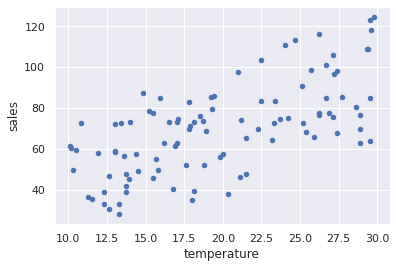

In [5]:
file_beer_sales_2.plot(x='temperature', y='sales', kind='scatter')

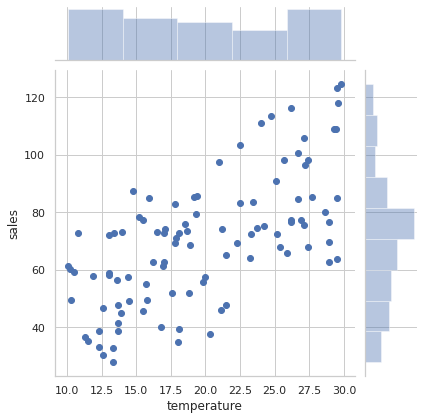

In [6]:
sns.set_style("whitegrid")
sns.jointplot(x="temperature",y="sales",data=file_beer_sales_2)

In [7]:
model = smf.ols('sales ~ temperature', data=file_beer_sales_2)
res = model.fit()
res.params

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Intercept      21.171660
temperature     2.459096
dtype: float64

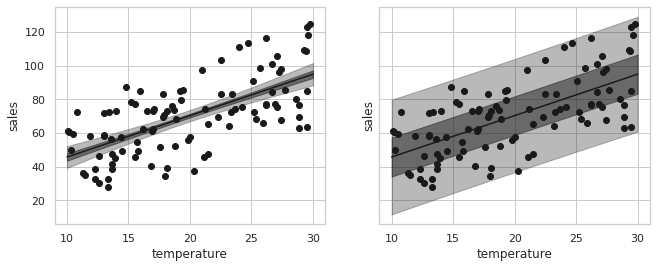

In [8]:
X_new = pd.DataFrame(data=np.arange(10, 31).reshape((-1, 1)), columns=['temperature'])
predictions = res.get_prediction(X_new)
int_95 = predictions.summary_frame(alpha=0.05)
int_50 = predictions.summary_frame(alpha=0.5)

x, y = X_new['temperature'], int_95['mean']

_, axes = plt.subplots(1, 2, figsize=figaspect(3/8), sharex=True, sharey=True)
for ax, category in zip(axes, ['mean', 'obs']):
    color = 'k'
    ax.scatter(file_beer_sales_2['temperature'], file_beer_sales_2['sales'], c=color)
    ax.plot(x, y, c=color)
    lower = '{}_ci_lower'.format(category)
    upper = '{}_ci_upper'.format(category)
    ax.fill_between(x, int_50[lower], int_50[upper], color=color, alpha=0.5)
    ax.fill_between(x, int_95[lower], int_95[upper], color=color, alpha=0.3)
    plt.setp(ax, xlabel='temperature', ylabel='sales')
plt.show()

In [9]:
with open("model/3-2-1-simple-lm.stan") as f:
    print(f.read())

data {
  int N;                  // サンプルサイズ
  vector[N] sales;        // 売り上げデータ
  vector[N] temperature;  // 気温データ
}

parameters {
  real Intercept;         // 切片
  real beta;              // 係数
  real<lower=0> sigma;    // 標準偏差
}

model {
  // 平均Intercept + beta*temperature
  // 標準偏差sigmaの正規分布に従ってデータが得られたと仮定
  for (i in 1:N) {
    sales[i] ~ normal(Intercept + beta*temperature[i], sigma);
  }
}



In [10]:
data = {'N':len(file_beer_sales_2),'sales':file_beer_sales_2['sales'],'temperature':file_beer_sales_2['temperature']}
data

{'N': 100, 'sales': 0      41.68
 1     110.99
 2      65.32
 3      72.64
 4      76.54
        ...  
 95     44.94
 96     76.11
 97     58.00
 98     38.65
 99     52.04
 Name: sales, Length: 100, dtype: float64, 'temperature': 0     13.7
 1     24.0
 2     21.5
 3     13.4
 4     28.9
       ... 
 95    13.9
 96    18.5
 97    11.9
 98    12.3
 99    18.8
 Name: temperature, Length: 100, dtype: float64}

In [11]:
stanmodel = StanModel(file="model/3-2-1-simple-lm.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_75accf505028bba5572c105072f99a10 NOW.


In [12]:
fit_nuts = stanmodel.sampling(data=data,n_jobs=-1)
fit_nuts

Inference for Stan model: anon_model_75accf505028bba5572c105072f99a10.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Intercept  21.16    0.17    5.9   9.75   17.2  21.11  25.12  32.82   1214    1.0
beta        2.46  8.4e-3   0.28   1.91   2.27   2.46   2.65    3.0   1141    1.0
sigma      17.12    0.03   1.28  14.83  16.22  17.06  17.94  19.79   1646    1.0
lp__      -330.2    0.04    1.3 -333.6 -330.7 -329.8 -329.2 -328.7   1297    1.0

Samples were drawn using NUTS at Wed Jul 29 09:46:41 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [13]:
with open("model/3-2-2-simple-lm-vec.stan") as f:
    print(f.read())

data {
  int N;                  // サンプルサイズ
  vector[N] sales;        // 売り上げデータ
  vector[N] temperature;  // 気温データ
}

parameters {
  real Intercept;         // 切片
  real beta;              // 係数
  real<lower=0> sigma;    // 標準偏差
}

model {
  // 平均Intercept + beta*temperature
  // 標準偏差sigmaの正規分布に従ってデータが得られたと仮定
  sales ~ normal(Intercept + beta*temperature, sigma);
}



In [14]:
sample_file = "sample/3-2-2-simple-lm-vec"
stanmodel = StanModel(file="model/3-2-2-simple-lm-vec.stan")


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b9e76e8f370b768c1b6faec53a5dd6b NOW.


In [15]:
fit_nuts = stanmodel.sampling(data=data,n_jobs=-1,sample_file=sample_file)
fit_nuts

Inference for Stan model: anon_model_8b9e76e8f370b768c1b6faec53a5dd6b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Intercept  21.16    0.16   5.98   9.63  17.12  21.12  25.29  32.87   1445    1.0
beta        2.46  7.7e-3   0.29   1.88   2.26   2.46   2.65   3.02   1425    1.0
sigma      17.05    0.03    1.2  14.87   16.2  16.99  17.83  19.61   2011    1.0
lp__      -330.1    0.03   1.22 -333.3 -330.7 -329.8 -329.2 -328.7   1571    1.0

Samples were drawn using NUTS at Wed Jul 29 09:47:57 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

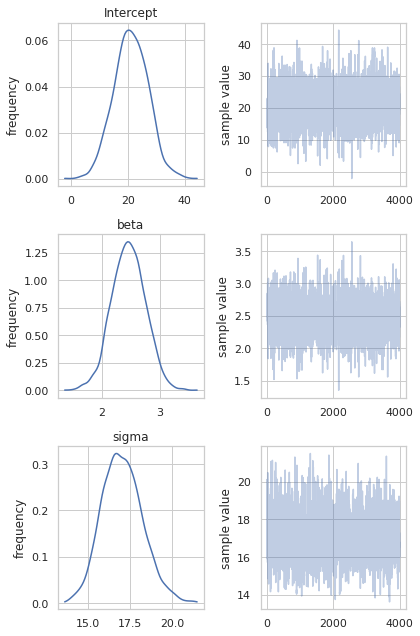

In [16]:
fit_nuts.plot()
plt.setp(plt.gcf(), size_inches=figaspect(3/2) * 1.5)
plt.tight_layout()

In [17]:
names = fit_nuts.sim['fnames_oi']
color_list = [mcolors.to_rgba(c) for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
chains = [pd.read_csv('{name}_{i}.csv'.format(name=sample_file, i=i), usecols=names, engine='python', comment='#') for i in range(fit_nuts.sim['chains'])]



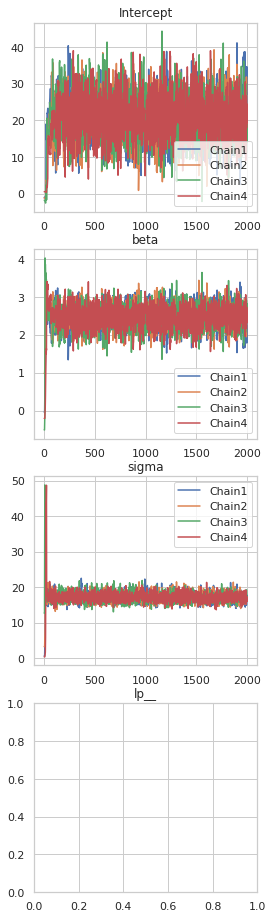

In [18]:
_, axes = plt.subplots(len(names), 1, figsize=figaspect(len(names)))
for name, ax in zip(names, axes):
    ax.set_title(name)
    # 対数尤度の描画は時間がかかるので省略
    if name == 'lp__':
        continue
    for i, chain in enumerate(chains):
        ax.plot(chain.index, chain[name], label='Chain{}'.format(i+1))
    ax.legend()

In [19]:
# モデルの保存にはpickleを利用
with open('model.pkl', 'wb') as f:
    pickle.dump(fit_nuts, f, protocol=pickle.HIGHEST_PROTOCOL)
# 並列計算はn_jobsで指定
stanmodel.sampling(data=data, n_jobs=-1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


Inference for Stan model: anon_model_8b9e76e8f370b768c1b6faec53a5dd6b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Intercept  21.38    0.15   5.72  10.26  17.58  21.25  25.22  32.71   1453    1.0
beta        2.45  7.3e-3   0.28    1.9   2.26   2.45   2.63   2.99   1448    1.0
sigma      17.05    0.03   1.26  14.79  16.17  16.97  17.84  19.76   1926    1.0
lp__      -330.1    0.03   1.25 -333.4 -330.6 -329.7 -329.2 -328.7   1284    1.0

Samples were drawn using NUTS at Wed Jul 29 09:48:02 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [20]:
with open('model.pkl', 'rb') as f:
    fit = pickle.load(f)
ms = fit.extract()

In [21]:
ms['beta']

array([2.38796872, 2.46806508, 1.92810693, ..., 2.30931726, 2.114146  ,
       2.32001791])

In [22]:
np.percentile(ms['beta'],(2.5,97.5))

array([1.87716147, 3.01649889])

In [23]:
N_mcmc = len(ms['lp__'])
y25_base = ms['Intercept'] + ms['beta']*25
y25 = np.random.normal(loc=y25_base,scale=ms['sigma'],size=N_mcmc)
d_mcmc = pd.DataFrame(data=dict(a=ms['Intercept'],b=ms['beta'],sigma=ms['sigma'],y25_base=y25_base,y25=y25))
d_mcmc.iloc[np.r_[:3,-1]]

,a,b,sigma,y25_base,y25
0,21.967817,2.387969,17.645050,81.667035,74.764709
1,23.769909,2.468065,16.478682,85.471536,93.562141
2,28.736494,1.928107,17.491633,76.939167,73.779301
3999,23.857372,2.320018,14.239570,81.857820,83.376262


In [24]:
d_mcmc.describe()

,a,b,sigma,y25_base,y25
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,21.155942,2.458179,17.050377,82.610422,82.413598
std,5.979985,0.290388,1.200715,2.319683,17.386778
min,-2.127814,1.354516,13.631662,74.546769,16.649639
25%,17.123026,2.260110,16.202038,81.008518,70.658695
50%,21.117437,2.459828,16.991128,82.617911,82.229405
75%,25.290469,2.650218,17.825212,84.185460,94.025046
max,44.356308,3.642429,21.485621,91.096062,142.977717


In [25]:
np.percentile(d_mcmc['y25'], (2.5, 97.5))

array([ 49.73286317, 117.18203191])

NameError: ignored

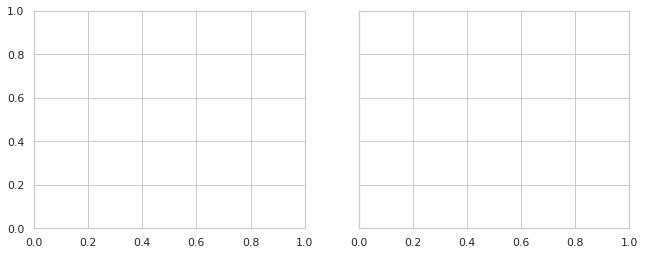

In [26]:
temps = np.arange(10,31)
steps = temps.size
median = np.empty(steps)
conf50 = np.empty((steps, 2))
conf95 = np.empty((steps, 2))
pred50 = np.empty((steps, 2))
pred95 = np.empty((steps, 2))
np.random.seed(1234)
for i, temp in enumerate(temps):
    base = ms['Intercept'] + ms['beta'] * temp
    y = np.random.normal(loc=base, scale=ms['sigma'], size=N_mcmc)
    median[i] = np.median(base)
    conf50[i] = np.percentile(base, (25, 75))
    pred50[i] = np.percentile(y, (25, 75))
    conf95[i] = np.percentile(base, (2.5, 97.5))
    pred95[i] = np.percentile(y, (2.5, 97.5))
_, axes = plt.subplots(1, 2, figsize=figaspect(3/8), sharex=True, sharey=True)
for interval50, interval95, ax in zip([conf50, pred50], [conf95, pred95], axes):
    color='k'
    ax.plot(ages, median, c=color)
    ax.scatter('temperature','sales', data=file_beer_sales_2, c=color)
    ax.fill_between(ages, interval50[:, 0], interval50[:, 1], color=color, alpha=0.5)
    ax.fill_between(ages, interval95[:, 0], interval95[:, 1], color=color, alpha=0.3)
    plt.setp(ax, xlabel='X', ylabel='Y')

In [ ]:
from scipy.stats import gaussian_kde

fit_smp = fit_nuts.extract()
s = pd.DataFrame(fit_smp['beta'])
s.plot(kind='kde')

data = fit_smp['beta']
density = gaussian_kde(data)

print(max(data))
xs = np.linspace(min(data),max(data),100)
plt.plot(xs,density(xs))

xs[np.argmax(density(xs))]

In [ ]:
para = ['Intercept','beta','sigma']
est = []
fig, axes = plt.subplots(nrows=len(para),figsize=(10,8))

for i in np.arange(len(para)):
    data = fit_smp[para[i]]
    density = gaussian_kde(data)
    xs = np.linspace(min(data),max(data),100)
    axes[i].plot(xs,density(xs))

    est.append(xs[np.argmax(density(xs))])
est 

In [ ]:
d = file_beer_sales_2.copy()

plt.scatter(d["temperature"],d["sales"])
x = np.linspace(min(d["temperature"]),max(d["temperature"]),100)
y = est[0]+est[1]*x
plt.plot(x,y)
plt.fill_between(x,y+est[2],y-est[2],facecolor='green',alpha=0.4)

In [ ]:
df = pd.DataFrame({'Intercept':fit_smp['Intercept'],'beta':fit_smp['beta'],'sigma':fit_smp['sigma']})
df.head()

df.shape

In [ ]:
sns.jointplot(x=df["Intercept"],y=df["beta"],data=df,alpha=0.1)

In [ ]:
#MCMCサンプリングの結果を抽出
ms = fit_nuts.extract(permuted=False, inc_warmup=True)

#ウォームアップ（バーンイン）のサイズを取得
iter_from = fit_nuts.sim['warmup']

#ウォームアップの区間を省いた区間
iter_range = np.arange(iter_from, ms.shape[0])

#各変数名を取得
paraname = fit_nuts.sim['fnames_oi']

#全て描画したいので、こちらを使う
iter_start = np.arange(0, ms.shape[0])

print(iter_from)
print(iter_start)
print(ms.shape[0])
print(fit_nuts.sim)

In [ ]:
# seabornおまじない
palette = sns.color_palette()
sns.set(font_scale=1)
sns.set_style("ticks")
sns.despine(offset=10, trim=True)
fig,axes  = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for i in range(2):
    for j in range(2):
        if i>1: l=6
        else: l=0
        axes[i,j].plot(iter_start, ms[iter_start, :, i*2+j], 
                       linewidth=2, color=palette[i*2+j-l])
        axes[i,j].set_title(paraname[i*2+j])
        axes[i,j].set_xlabel('mcmc_size')
        axes[i,j].set_ylabel('parameter')
        axes[i,j].grid(True)
plt.tight_layout()

In [ ]:
N_mcmc = len(ms['lp__'])
N_mcmc

In [ ]:
salary = pd.read_csv('./input/data-salary.txt', header=0)
salary.head()

In [ ]:
salary.iloc[np.r_[0:3, -1]]

In [ ]:
salary.plot(x='X', y='Y', kind='scatter')

In [ ]:
model = smf.ols('Y ~ X', data=salary)
res = model.fit()
res.params

In [ ]:
X_new = pd.DataFrame(data=np.arange(23, 61).reshape((-1, 1)), columns=['X'])
predictions = res.get_prediction(X_new)
int_95 = predictions.summary_frame(alpha=0.05)
int_50 = predictions.summary_frame(alpha=0.5)

x, y = X_new['X'], int_95['mean']

_, axes = plt.subplots(1, 2, figsize=figaspect(3/8), sharex=True, sharey=True)
for ax, category in zip(axes, ['mean', 'obs']):
    color = 'k'
    ax.scatter(salary['X'], salary['Y'], c=color)
    ax.plot(x, y, c=color)
    lower = '{}_ci_lower'.format(category)
    upper = '{}_ci_upper'.format(category)
    ax.fill_between(x, int_50[lower], int_50[upper], color=color, alpha=0.5)
    ax.fill_between(x, int_95[lower], int_95[upper], color=color, alpha=0.3)
    plt.setp(ax, xlabel='X', ylabel='Y')
plt.show()

In [ ]:
sample_file = 'sample/model4-5'
data = dict(
    N=salary.index.size,
    X=salary['X'],
    Y=salary['Y']
)
fit = pystan.stan(file='model/model4-5.stan', data=data, seed=1234, sample_file=sample_file)

In [ ]:
fit

In [ ]:
fit.plot()
plt.setp(plt.gcf(), size_inches=figaspect(3/2) * 1.5)
plt.tight_layout()

In [ ]:
names = fit.sim['fnames_oi']
color_list = [mcolors.to_rgba(c) for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
chains = [pd.read_csv('{name}_{i}.csv'.format(name=sample_file, i=i), usecols=names, engine='python', comment='#') for i in range(fit.sim['chains'])]

_, axes = plt.subplots(len(names), 1, figsize=figaspect(len(names)))
for name, ax in zip(names, axes):
    ax.set_title(name)
    # 対数尤度の描画は時間がかかるので省略
    if name == 'lp__':
        continue
    for i, chain in enumerate(chains):
        ax.plot(chain.index, chain[name], label='Chain{}'.format(i+1))
    ax.legend()

In [ ]:
plt.scatter('X', 'Y', data=salary, c=color)

# 統計学が最強の学問である［数学編］

(0.0, 12.0)

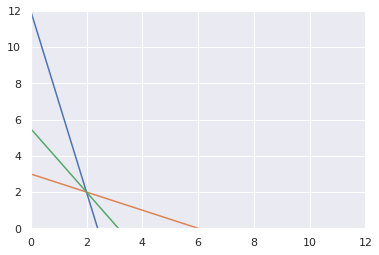

In [29]:
y1 = lambda x : 12-5*x
y2 = lambda x : 3-0.5*x
y3 = lambda x : 22/4-7/4*x

x = np.linspace(0,12,50)
plt.plot(x, y1(x))
plt.plot(x, y2(x))
plt.plot(x, y3(x))
plt.xlim(0,12)
plt.ylim(0,12)

In [30]:
import sympy
x =sympy.Symbol('x')
y = sympy.Symbol('y')
a,b,c,p,q = sympy.symbols('a b c p q')

print(type(a))

<class 'sympy.core.symbol.Symbol'>


In [31]:
y1 = 12-5*x-y
y2 = 3-0.5*x-y

In [32]:
sympy.solve([y1,y2])

{x: 2.00000000000000, y: 2.00000000000000}

In [33]:
x=2; y=2
z = 7*x + 4*y
z

22

In [36]:
# !pip install pulp

from pulp import *
from itertools import product
from fractions import Fraction as frac

In [37]:
def complete_square(a,b,c):
  p,q = frac(b,2*c), frac(-b*b,4*c)+a
  print(f'平方完成 : y = {c}*(x+({p}))**2+({q})')
  return float(-p),float(q)

In [38]:
a = frac(5,6)
b = frac(3,4)
c = frac(1,2)

y = lambda x: a+b*x+c*x**2

In [39]:
extremum_point = complete_square(a,b,c)
print('座標 : ', extremum_point)


平方完成 : y = 1/2*(x+(3/4))**2+(53/96)
座標 :  (-0.75, 0.5520833333333334)


In [40]:
x =sympy.Symbol('x')
y = sympy.Symbol('y')
a,b,c,p,q = sympy.symbols('a b c p q')


y3 = a+b+c-10
y4 = a+2*b+4*c-40
y5 = a+3*b+9*c-82



ans = sympy.solve([y3,y4,y5])

In [41]:
df = pd.DataFrame({'訪問回数':[100,200,300],'契約回数':[10,40,82]},index=['1年目','2年目','3年目'])
df

,訪問回数,契約回数
1年目,100,10
2年目,200,40
3年目,300,82


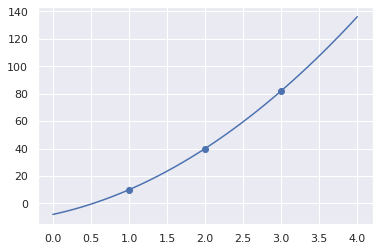

In [42]:
y4 = lambda x :ans[a]+ans[b]*x+ans[c]*x**2
x = np.linspace(0,4,50)
plt.plot(x,y4(x))
plt.scatter(df['訪問回数']/100,df['契約回数'])

In [43]:
y4(4)

136

(0.0, 5.0)

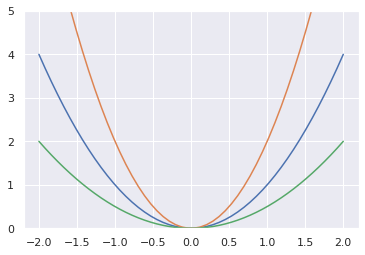

In [44]:
x = np.linspace(-2,2,50)
plt.plot(x,x**2)
plt.plot(x,2*x**2)
plt.plot(x,0.5*x**2)
plt.ylim(0,5)

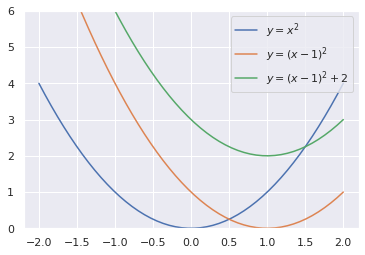

In [45]:
x = np.linspace(-2,2,50)
plt.plot(x,x**2,label="$ y = x^2 $")
plt.plot(x,(x-1)**2,label="$ y = (x-1)^2 $")
plt.plot(x,(x-1)**2+2,label="$ y = (x-1)^2+2 $")
plt.ylim(0,6)
plt.legend(loc='best')

$ y = c(x-p)^2+q $ 　二次関数の「標準形」

In [46]:
df = pd.DataFrame({'平均購買金額':[676,936,996]},index=['月に１回','月に２回','月に３回'])
df

,平均購買金額
月に１回,676
月に２回,936
月に３回,996


(0.0, 1200.0)

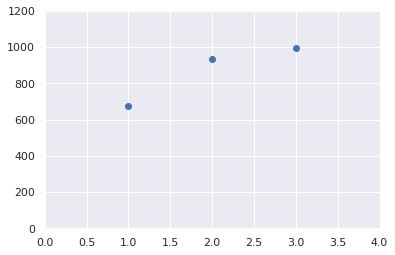

In [47]:
x = np.arange(3)
plt.scatter(x+1,df['平均購買金額'])
plt.xlim(0,4)
plt.ylim(0,1200)

In [48]:
x =sympy.Symbol('x')
y = sympy.Symbol('y')
a,b,c,p,q = sympy.symbols('a b c p q')

y3 = a+b+c-676
y4 = a+2*b+4*c-936
y5 = a+3*b+9*c-996

ans = sympy.solve([y3,y4,y5])



In [49]:
ans

{a: 216, b: 560, c: -100}

(0.0, 1200.0)

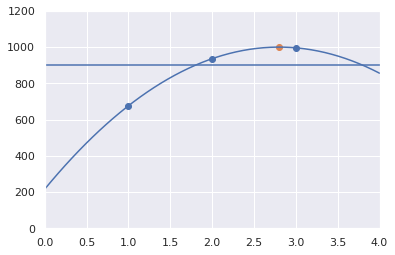

In [50]:
y4 = lambda x :ans[a]+ans[b]*x+ans[c]*x**2
x = np.linspace(0,4,50)
plt.plot(x,y4(x))
xx = np.arange(3)
plt.scatter(xx+1,df['平均購買金額'])
plt.scatter(2.8,y4(2.8))
plt.axhline(y=900,xmin=0,xmax=4)
plt.xlim(0,4)
plt.ylim(0,1200)

In [ ]:
y4(2.8)

In [ ]:
x =sympy.Symbol('x')
y = sympy.Symbol('y')

a = ans[a]
b = ans[b]
c = ans[c]

g = a+b*x+c*x**2

g

In [ ]:
f = sympy.diff(g)
f

In [ ]:
a = 216
b = 560
c = -100

y = lambda x: a+b*x+c*x**2

extremum_point = complete_square(a,b,c)
print('座標 : ', extremum_point)